# ML-7. Оптимизация гиперпараметров модели

## 2. DST-95 Aleksandr Ivanov

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

### Описание задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).


### Data Upload (no need EDA)

In [2]:
data = pd.read_csv('data/_train_sem09.csv')

data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Смотрим на сбалансированность классов:

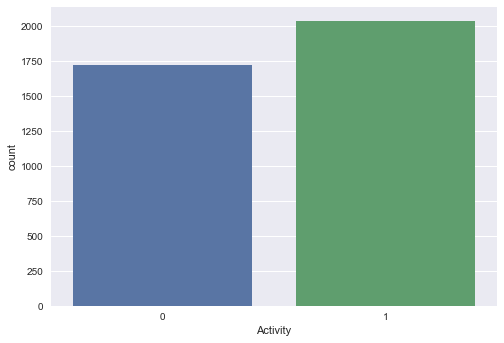

In [3]:
sns.countplot(data=data, x='Activity');

Внешне похоже на то, что наши классы сбалансированы.

In [4]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение), что незначительно повысит точность предсказаний. Стратификация обязательно применяется для разбалансированных классов.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [6]:
#Создаем объект класса логистическая регрессия
#установим параметры лог регрессии, по традиции random_state зададим на уровне 42, а количество мах итераций 500 (для избежания ошибок алгоритма оптимизации)
log_reg = linear_model.LogisticRegression(random_state = 42, max_iter=500)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.88
f1_score на тестовом наборе: 0.78


In [7]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.81


### <center> **GridSearchCV**

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=500 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = 50
)  
%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred))) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))


Wall time: 3min 49s
f1_score на обучающем наборе: 0.88
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}
Наилучшая модель:
LogisticRegression(max_iter=500, random_state=42)
Наилучшее значение точности при кросс-валидаци: 0.75


In [9]:
# результаты кросс-валидации
result_cv = pd.DataFrame(grid_search.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.321725,1.479127,0.510036,0.252319,l2,lbfgs,"{'penalty': 'l2', 'solver': 'lbfgs'}",0.725000,0.748333,0.746667,0.756667,0.756667,0.746667,0.011595,1
1,196.771214,6.672686,0.119984,0.059911,l2,saga,"{'penalty': 'l2', 'solver': 'saga'}",0.723333,0.748333,0.753333,0.756667,0.750000,0.746333,0.011851,2


In [10]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_penalty', 'param_solver', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [11]:
param_grid = {'n_estimators': list(range(80, 100, 10)),
              'min_samples_leaf': [5,7],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = 50
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))
print("Наилучшая модель:\n{}".format(grid_search_forest.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search_forest.best_score_))

Wall time: 1min 31s
f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 80}
Наилучшая модель:
RandomForestClassifier(max_depth=20, min_samples_leaf=7, n_estimators=80,
                       random_state=42)
Наилучшее значение точности при кросс-валидаци: 0.78


In [12]:
# результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_forest.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.325609,0.522057,1.329692,0.869363,20,5,80,"{'max_depth': 20, 'min_samples_leaf': 5, 'n_es...",0.768333,0.788333,0.795000,0.776667,0.775000,0.780667,0.009638,20
1,13.607907,11.451097,1.788786,0.379347,20,5,90,"{'max_depth': 20, 'min_samples_leaf': 5, 'n_es...",0.770000,0.793333,0.798333,0.778333,0.776667,0.783333,0.010698,7


In [13]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_n_estimators',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

### <center> **RandomizedSearchCV**

In [14]:
from sklearn.model_selection import RandomizedSearchCV

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag']
               },
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=500), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_train_pred = random_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

c:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Wall time: 3min 12s
f1_score на обучающем наборе: 0.88
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2'}


In [16]:
param_distributions = {'n_estimators': list(range(80, 100, 10)),
              'min_samples_leaf': [5,7],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50,
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

c:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Wall time: 1min 2s
f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 80, 'min_samples_leaf': 7, 'max_depth': 20}


## 3. Продвинутая оптимизация.

### <center> Hyperopt

In [17]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.5


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

In [38]:
# зададим пространство поиска гиперпараметров
space={'penalty': hp.choice('penalty', ['l2', 'none']),
       'solver': hp.choice('solver', ['lbfgs', 'sag'])
      }

In [39]:
from hyperopt.pyll.stochastic import sample as ho_sample
ho_sample(space)

{'penalty': 'l2', 'solver': 'sag'}

In [20]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'],
              'solver': params['solver']
             }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
# начинаем подбор гиперпараметров
#%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

In [ ]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=best['penalty'],
    solver=best['solver'])

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [23]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 80, 100, 10),
       'max_depth' : hp.quniform('max_depth', 20, 40, 5),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 7, 2)
      }

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [24]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [25]:
# начинаем подбор гиперпараметров
#%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [01:40<00:00,  2.02s/trial, best loss: -0.9341903887358433]
Наилучшие значения гиперпараметров {'max_depth': 30.0, 'min_samples_leaf': 6.0, 'n_estimators': 100.0}


In [26]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.81


## <center> Optuna

In [27]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 2.10.1


In [28]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ["l2", "none"])
  solver = trial.suggest_categorical('solver', ["lbfgs", "sag"])

  # создаем модель
  model = linear_model.LogisticRegression(solver=solver,
                                          penalty=penalty,
                                          random_state=random_state,
                                          max_iter=500)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  

In [29]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="Logistic Regression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2022-08-19 15:45:32,552] A new study created in memory with name: Logistic Regression
c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2022-08-19 15:46:11,377] Trial 0 finished with value: 0.9172519083969467 and parameters: {'penalty': 'none', 'solver': 'sag'}. Best is trial 0 with value: 0.9172519083969467.
c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2022-08-19 15:46:15,293] Trial 1 finishe

Wall time: 7min 57s


In [30]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs'}
f1_score на обучающем наборе: 0.96


In [31]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, max_iter=500)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.96
f1_score на тестовом наборе: 0.73


c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [32]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 80, 100, 10)
  max_depth = trial.suggest_int('max_depth', 20, 40, 5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 7, 2)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  
  

In [33]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2022-08-19 15:53:34,976] A new study created in memory with name: RandomForestClassifier
[I 2022-08-19 15:53:37,032] Trial 0 finished with value: 0.9435803598658127 and parameters: {'n_estimators': 90, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9435803598658127.
[I 2022-08-19 15:53:39,064] Trial 1 finished with value: 0.923640806353085 and parameters: {'n_estimators': 90, 'max_depth': 35, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9435803598658127.
[I 2022-08-19 15:53:40,710] Trial 2 finished with value: 0.923076923076923 and parameters: {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9435803598658127.
[I 2022-08-19 15:53:43,031] Trial 3 finished with value: 0.9441903019213176 and parameters: {'n_estimators': 100, 'max_depth': 35, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.9441903019213176.
[I 2022-08-19 15:53:45,086] Trial 4 finished with value: 0.942970417810308 and parameters: {'n_estima

Wall time: 1min 36s


In [34]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 90, 'max_depth': 25, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.95


In [35]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.95
f1_score на тестовом наборе: 0.83
